#Практическая работа №3.
#Выполнил Тораев А.И. Группа №25.

Данная работа выполнена при прохождении курса "Разработчик нейросетей" на платформе "THE FOUNDER".  
Мною была выбрана тема "Применение Vision Transformer (ViT) для анализа спутниковых снимков в задачах мониторинга экологической обстановки".

# Установка и импорт библиотек

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from transformers import ViTForImageClassification, ViTFeatureExtractor
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt

# Теоретическая часть

Проблема отслеживания изменения поверхности земли с помощью снимков со спутника хорошо описывается в статье "Vision Transformer for Multispectral Satellite Imagery: Advancing Landcover Classification" (https://openaccess.thecvf.com/content/WACV2024/papers/Rad_Vision_Transformer_for_Multispectral_Satellite_Imagery_Advancing_Landcover_Classification_WACV_2024_paper.pdf).  
Мною же реализовано дообучение модели с huggingface "google/vit-base-patch16-224" для проведения классификации спутниковых снимков.

# Подготовка данных

In [ ]:
# Подключяаем гугл-диск для загрузки датасета
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/EuroSAT_RGB.zip '.'

In [ ]:
!unzip -q EuroSAT_RGB.zip

In [ ]:
!ls /content/EuroSAT_RGB

AnnualCrop  HerbaceousVegetation  Industrial  PermanentCrop  River
Forest	    Highway		  Pasture     Residential    SeaLake


In [ ]:
folders_path = '/content/EuroSAT_RGB/'

In [ ]:
# 1. Создание пользовательского Dataset для спутниковых снимков
class SatelliteImageDataset(Dataset):
    def __init__(self, main_folder, img_num, transform=None):
        """
        Args:
            main_folder (str): Путь к главной папке с подпапками-классами.
            transform (callable, optional): Преобразования, применяемые к изображениям.
        """
        self.main_folder = main_folder
        self.transform = transform

        # Собираем список всех изображений и их меток
        self.image_paths = []
        self.labels = []
        self.label_names = set()

        # Проходим по всем подпапкам (классам)
        for label in os.listdir(main_folder):
            class_folder = os.path.join(main_folder, label)
            if os.path.isdir(class_folder):
                # Проходим по всем изображениям в папке класса
                for image_name in os.listdir(class_folder):
                    if self.labels.count(label) < img_num:
                        image_path = os.path.join(class_folder, image_name)
                        if os.path.isfile(image_path):
                            self.image_paths.append(image_path)
                            self.labels.append(label)
                            self.label_names.add(label)

        # Преобразуем метки в числовой формат
        self.label_to_idx = {label: idx for idx, label in enumerate(set(self.labels))}
        self.idx_to_label = {idx: label for label, idx in self.label_to_idx.items()}
        self.labels = [self.label_to_idx[label] for label in self.labels]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        Возвращает изображение и его метку по индексу.
        """
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        # Загружаем изображение
        image = Image.open(image_path).convert("RGB")  # Конвертируем в RGB

        # Применяем преобразования, если они заданы
        if self.transform:
            image = self.transform(image)

        return image, label

# 2. Предобработка данных
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ViT ожидает изображения 224x224
    transforms.ToTensor(),          # Преобразуем в тензор
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Нормализация
])

dataset = SatelliteImageDataset(main_folder=folders_path, img_num=80, transform=transform)

In [ ]:
len(dataset)

800

In [ ]:
label_names = list(dataset.label_names)

In [ ]:
label_count = []
for lbl in set(dataset.labels):
    label_count.append(dataset.labels.count(lbl))

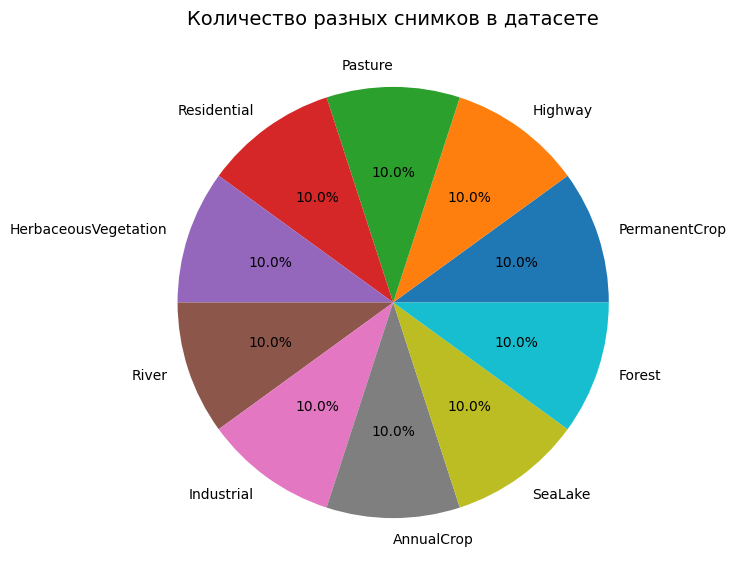

In [ ]:
plt.figure(figsize=(9, 7))
plt.pie(label_count,
        labels=label_names,
        autopct='%.1f%%',)
plt.title('Количество разных снимков в датасете', fontsize=14)
plt.show()

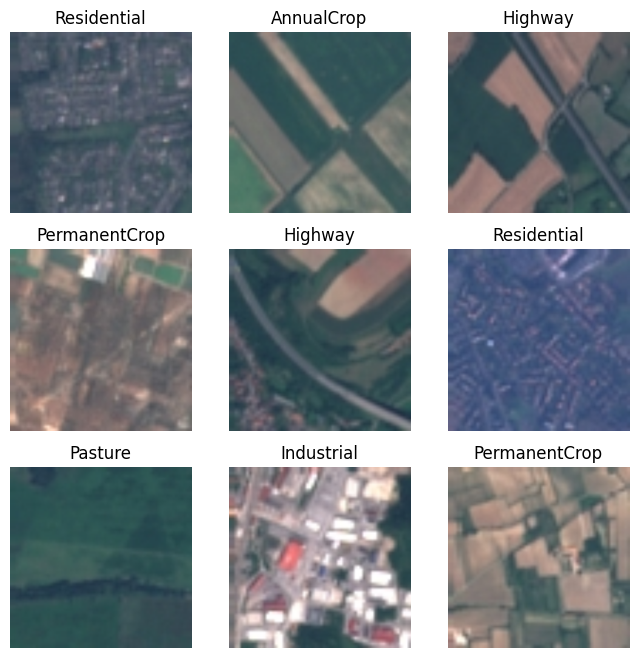

In [ ]:
# Рассмотрим некоторые изображения из датасета
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(dataset), size=(1,)).item()
    img, label = dataset[sample_idx]
    img = img / 2 + 0.5
    img = img.numpy()
    img = np.transpose(img, (1, 2, 0))
    figure.add_subplot(rows, cols, i)
    plt.title(label_names[label])
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()

In [ ]:
# Создадим тренировочный, тестовый и валидационный даталоадер
train_ds, test_ds, val_ds = torch.utils.data.random_split(dataset, [700, 50, 50])
train_dataloader = DataLoader(train_ds, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_ds, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_ds, batch_size=8, shuffle=True)

In [ ]:
HF_TOKEN = 'HERE SHOULD BE YOUR HUGGING FACE TOKEN'

# Реализация модели

In [ ]:
# 4. Загрузка предобученной модели ViT
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",  # Модель ViT
    num_labels=len(label_names),  # Количество классов (замените на ваше количество классов)
    ignore_mismatched_sizes=True
)
# 5. Настройка оптимизатора и функции потерь
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Обучение модели

In [ ]:
# 6. Обучение модели
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    image_num = 1
    for images, labels in train_dataloader:

        # Обнуляем градиенты
        optimizer.zero_grad()

        # Прямой проход
        outputs = model(images).logits
        loss = criterion(outputs, labels)

        # Обратный проход и оптимизация
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        print(f'Loss for step {image_num} and epoch {epoch+1}: {loss}')
        image_num+=1

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_dataloader):.4f}")

Loss for step 1 and epoch 1: 2.3132870197296143
Loss for step 2 and epoch 1: 2.3752846717834473
Loss for step 3 and epoch 1: 2.040996551513672
Loss for step 4 and epoch 1: 2.0961246490478516
Loss for step 5 and epoch 1: 1.5686928033828735
Loss for step 6 and epoch 1: 1.660980224609375
Loss for step 7 and epoch 1: 2.416818618774414
Loss for step 8 and epoch 1: 1.6514368057250977
Loss for step 9 and epoch 1: 1.4188059568405151
Loss for step 10 and epoch 1: 1.481605052947998
Loss for step 11 and epoch 1: 1.2447035312652588
Loss for step 12 and epoch 1: 1.3488401174545288
Loss for step 13 and epoch 1: 1.8607560396194458
Loss for step 14 and epoch 1: 1.1340198516845703
Loss for step 15 and epoch 1: 0.8237386345863342
Loss for step 16 and epoch 1: 1.3558660745620728
Loss for step 17 and epoch 1: 1.30536949634552
Loss for step 18 and epoch 1: 1.0284500122070312
Loss for step 19 and epoch 1: 0.8009355068206787
Loss for step 20 and epoch 1: 0.5474950075149536
Loss for step 21 and epoch 1: 0.849

# Оценка результатов

In [ ]:
# 7. Оценка модели
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_dataloader:
        outputs = model(images).logits
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy: {100 * correct / total:.2f}%")

Accuracy: 96.00%


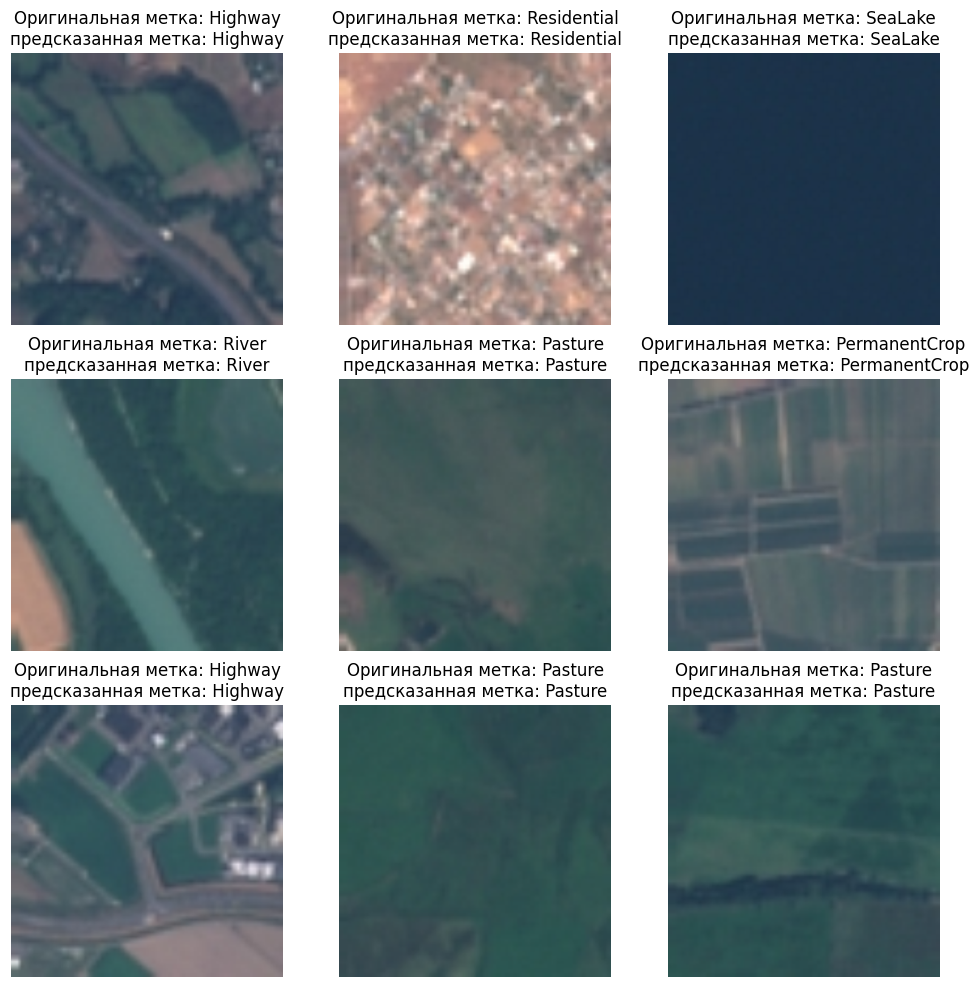

In [ ]:
figure = plt.figure(figsize=(12, 12))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(val_ds), size=(1,)).item()
    img, label = val_ds[sample_idx]
    input_tensor = img.unsqueeze(0)  # Добавляем batch dimension
    # Передача изображения через модель
    with torch.no_grad():
        outputs = model(input_tensor)
    # Получение логитов и применение softmax для получения вероятностей
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=-1)
    # Определение предсказанного класса
    predicted_class_idx = torch.argmax(probabilities, dim=1).item()
    # predicted_probability = probabilities[0, predicted_class_idx].item()
    # print(predicted_probability)
    img = img / 2 + 0.5
    img = img.numpy()
    img = np.transpose(img, (1, 2, 0))
    figure.add_subplot(rows, cols, i)
    plt.title(f'Оригинальная метка: {label_names[label]}\nпредсказанная метка: {label_names[predicted_class_idx]}')
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()

Для такого небольшого количества обучающих данных получена хорошая точность определения класса. Такой небольшой объем обучающих данных вызван тем, что значительно увеличивается время обучения модели.

# Выводы

В ходе обучения модели удалось дообучить предобученную модель "google/vit-base-patch16-224" для предсказания класса космического снимка с большой точностью. Для оценки изменения поверхности земли в дальнейшем необходимо доработать данную модель так, что бы она показывала различия между двумя спутниковыми снимками.